In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 107.4 MB/s eta 0:00:

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [3]:
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=False)
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 137995543.21it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25534505.44it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48490716.06it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6119668.73it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            #nn.Linear(64, 12),  nn.ReLU(True),
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 28 * 28), nn.Tanh())
    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [5]:
!pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [6]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000  trn_loss: 0.254  val_loss: 0.190  (34.98s - 139.91s remaining)
EPOCH: 2.000  trn_loss: 0.178  val_loss: 0.170  (56.82s - 85.24s remaining)
EPOCH: 3.000  trn_loss: 0.164  val_loss: 0.160  (76.59s - 51.06s remaining)
EPOCH: 4.000  trn_loss: 0.157  val_loss: 0.155  (99.61s - 24.90s remaining)
EPOCH: 5.000  trn_loss: 0.153  val_loss: 0.152  (119.58s - 0.00s remaining)


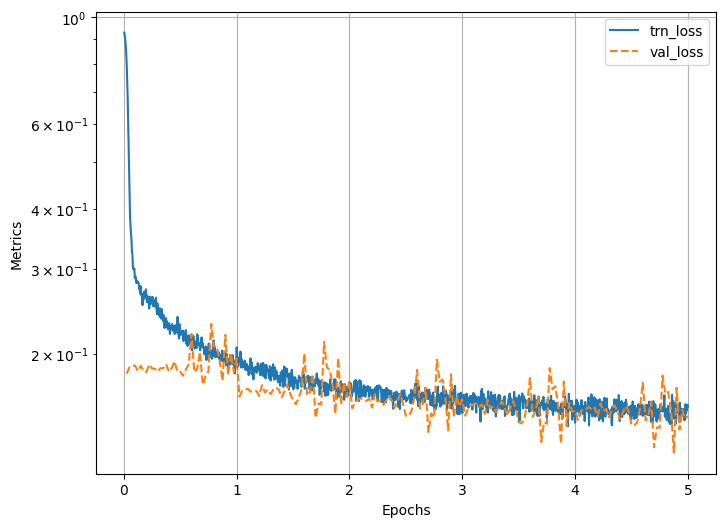

In [7]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

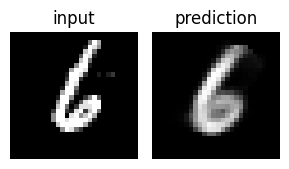

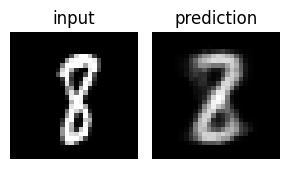

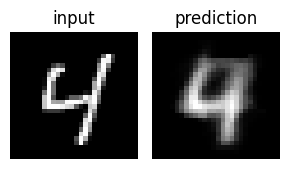

In [8]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

EPOCH: 1.000  trn_loss: 0.236  val_loss: 0.139  (19.75s - 78.98s remaining)
EPOCH: 2.000  trn_loss: 0.117  val_loss: 0.100  (40.46s - 60.70s remaining)
EPOCH: 3.000  trn_loss: 0.092  val_loss: 0.083  (69.42s - 46.28s remaining)
EPOCH: 4.000  trn_loss: 0.080  val_loss: 0.074  (87.85s - 21.96s remaining)
EPOCH: 5.000  trn_loss: 0.072  val_loss: 0.066  (106.93s - 0.00s remaining)


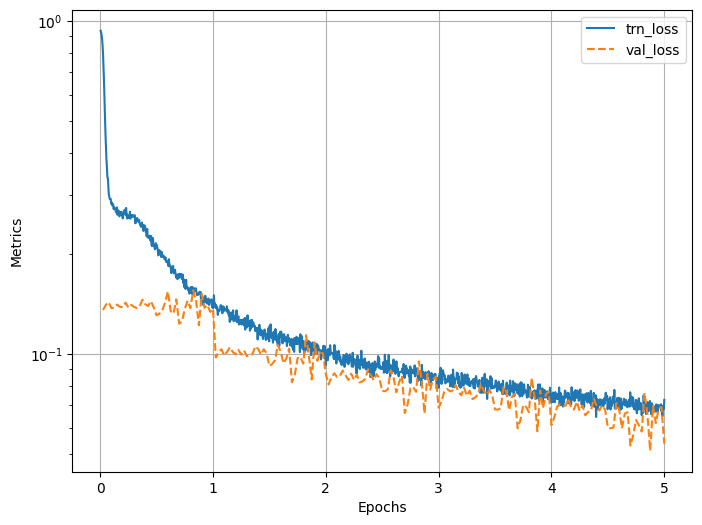

EPOCH: 1.000  trn_loss: 0.264  val_loss: 0.214  (19.91s - 79.63s remaining)
EPOCH: 2.000  trn_loss: 0.204  val_loss: 0.191  (40.57s - 60.85s remaining)
EPOCH: 3.000  trn_loss: 0.185  val_loss: 0.179  (61.67s - 41.11s remaining)
EPOCH: 4.000  trn_loss: 0.177  val_loss: 0.173  (81.67s - 20.42s remaining)
EPOCH: 5.000  trn_loss: 0.172  val_loss: 0.169  (102.80s - 0.00s remaining)


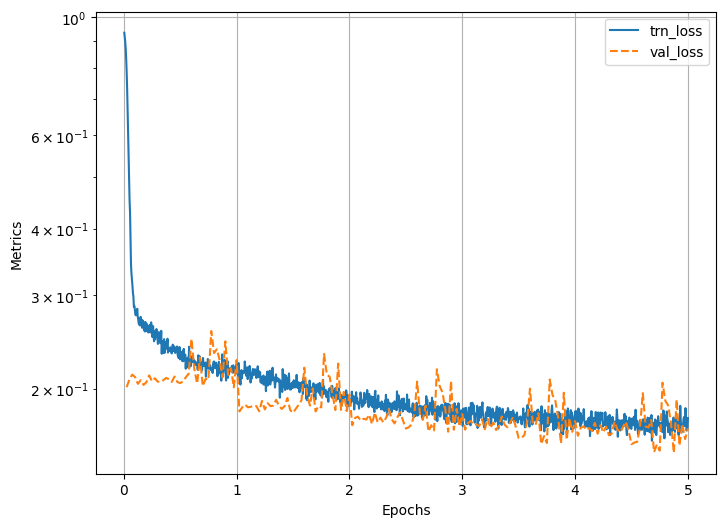

EPOCH: 1.000  trn_loss: 0.260  val_loss: 0.190  (19.32s - 77.28s remaining)
EPOCH: 2.000  trn_loss: 0.177  val_loss: 0.168  (40.22s - 60.33s remaining)
EPOCH: 3.000  trn_loss: 0.162  val_loss: 0.158  (59.25s - 39.50s remaining)
EPOCH: 4.000  trn_loss: 0.155  val_loss: 0.154  (79.39s - 19.85s remaining)
EPOCH: 5.000  trn_loss: 0.152  val_loss: 0.151  (98.84s - 0.00s remaining)


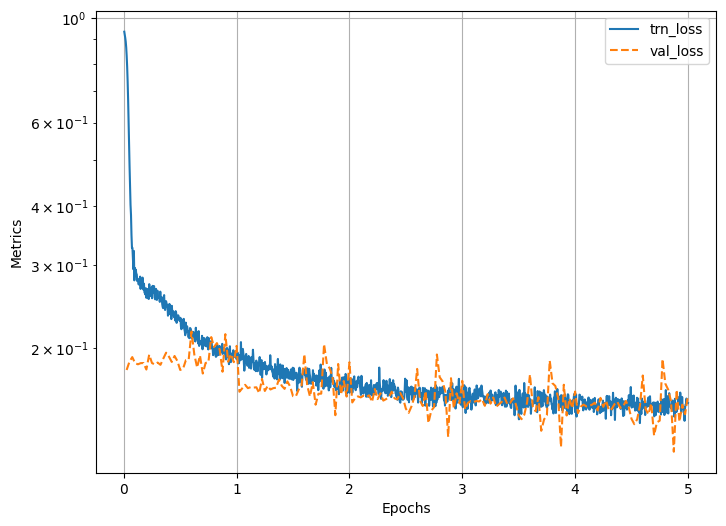

EPOCH: 1.000  trn_loss: 0.251  val_loss: 0.169  (19.86s - 79.45s remaining)
EPOCH: 2.000  trn_loss: 0.153  val_loss: 0.139  (39.91s - 59.86s remaining)
EPOCH: 3.000  trn_loss: 0.133  val_loss: 0.127  (58.87s - 39.25s remaining)
EPOCH: 4.000  trn_loss: 0.124  val_loss: 0.122  (78.67s - 19.67s remaining)
EPOCH: 5.000  trn_loss: 0.120  val_loss: 0.118  (97.71s - 0.00s remaining)


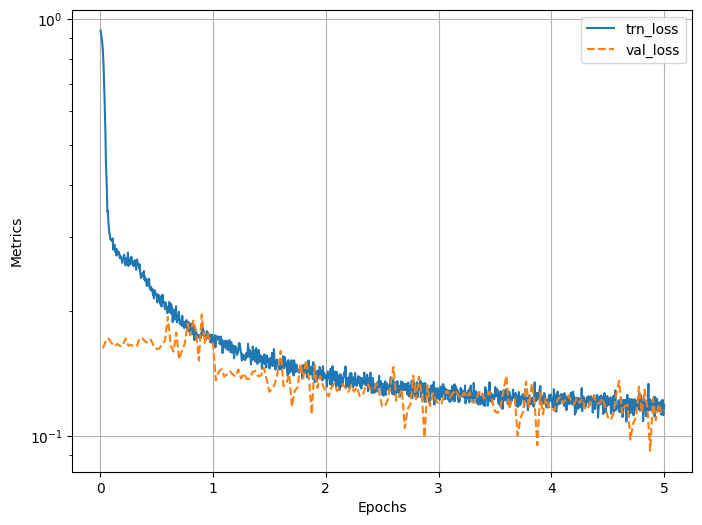

EPOCH: 1.000  trn_loss: 0.244  val_loss: 0.159  (19.68s - 78.73s remaining)
EPOCH: 2.000  trn_loss: 0.133  val_loss: 0.115  (38.47s - 57.70s remaining)
EPOCH: 3.000  trn_loss: 0.109  val_loss: 0.102  (58.06s - 38.71s remaining)
EPOCH: 4.000  trn_loss: 0.100  val_loss: 0.096  (76.97s - 19.24s remaining)
EPOCH: 5.000  trn_loss: 0.095  val_loss: 0.091  (96.58s - 0.00s remaining)


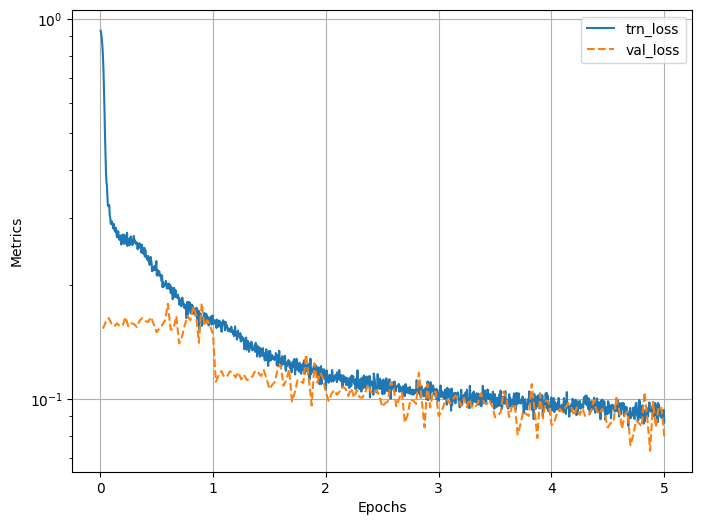

In [10]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

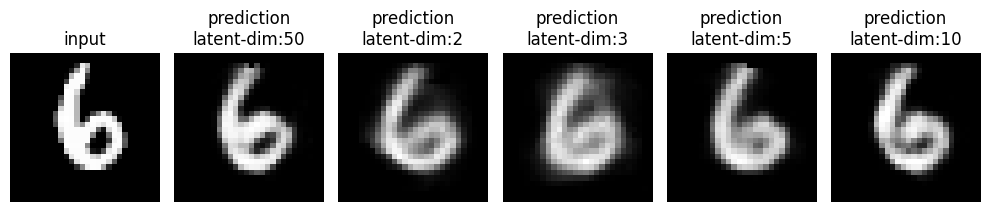

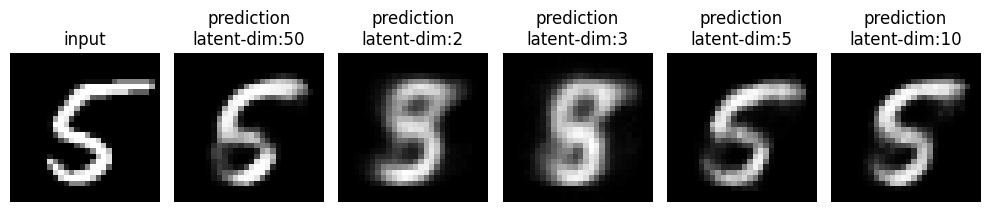

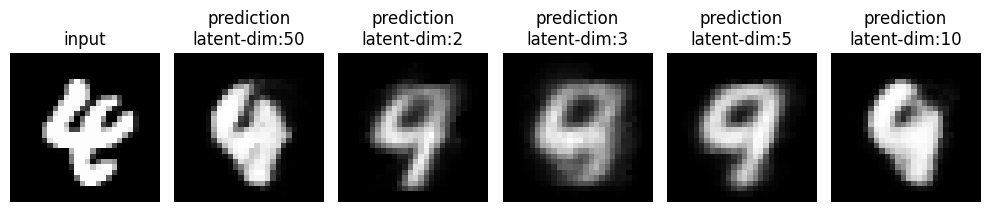

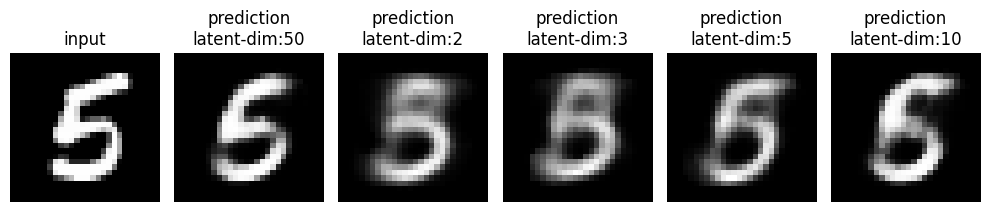

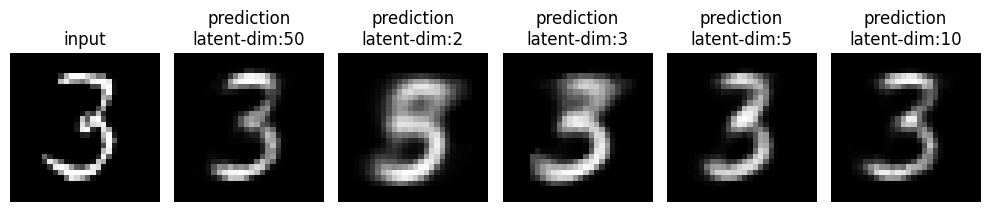

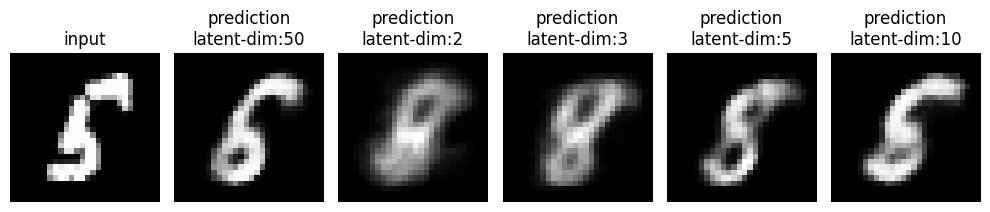

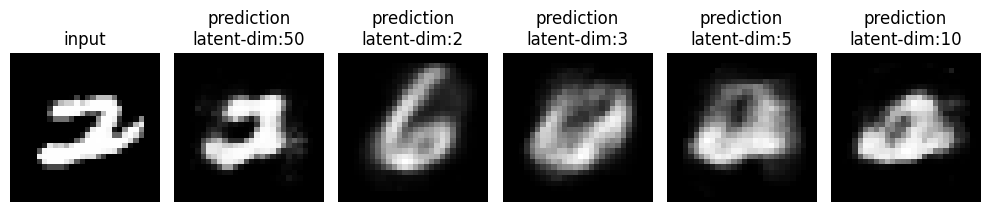

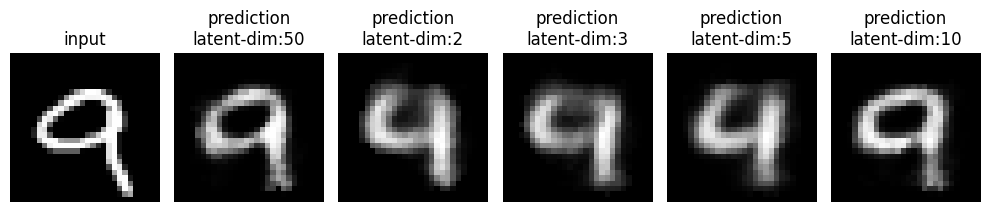

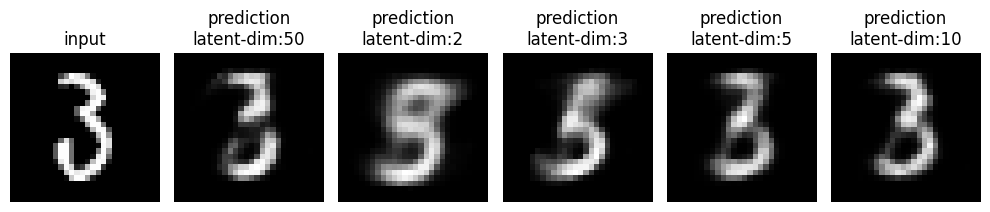

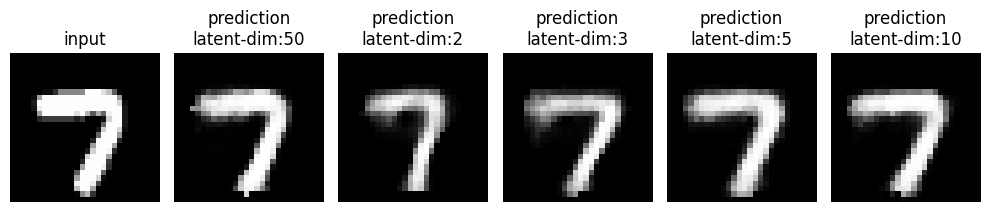

In [11]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()

---